In [2]:
from pyspark.sql import Window
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, when, count, max
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
)
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import os

In [3]:
spark = (
    SparkSession.builder.config("spark.executor.memory", "8g")
    .config("spark.cores.max", "4")
    .getOrCreate()
)
sc = spark.sparkContext


In [4]:
df_2000_2004 = spark.read.option("header", "true").csv("./200[0-4].csv")
df_2005 = spark.read.option("header", "true").csv("./2005.csv")

# Data Preprocess
### Feature selection
- Month
- DayOfWeek
- CRSDepTime
- CRSArrTime
- UniqueCarrier
- FlightNum
- Origin
- Dest
- Distance

In [5]:
features = [
    "Month",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "Origin",
    "Dest",
    "Distance",
    "cancelled",
]
train_df = (
    df_2000_2004.select(features)
    .withColumn("label", df_2000_2004["cancelled"].cast("float"))
)
train_df = train_df.filter(train_df["label"].isNotNull())
test_df = (
    df_2005.select(features)
    .withColumn("label", df_2005["cancelled"].cast("float"))
)
test_df = test_df.filter(test_df["label"].isNotNull())

for col in train_df.columns:
    train_df = train_df.filter(train_df[col].isNotNull())
    test_df = test_df.filter(test_df[col].isNotNull())

### Undersampling

In [6]:
no_cancelled_df = train_df.filter(train_df["label"] == 0)
cancelled_df = train_df.filter(train_df["label"] == 1)
ratio = int(no_cancelled_df.count()/cancelled_df.count())
no_cancelled_df = no_cancelled_df.sample(False, 1/ratio)
train_df = no_cancelled_df.unionAll(cancelled_df)

### Preparing Data for Machine Learning

In [9]:
def train(model, train_df):
    features = [
        "Month",
        "DayOfWeek",
        "CRSDepTime",
        "CRSArrTime",
        "UniqueCarrier",
        "FlightNum",
        "Origin",
        "Dest",
        "Distance",
    ]
    model_obj = {
        "lr": LogisticRegression(featuresCol="features", labelCol="label", maxIter=10),
        "dt": DecisionTreeClassifier(
            featuresCol="features", labelCol="label", maxDepth=3
        ),
        "rf": RandomForestClassifier(featuresCol="features", labelCol="label"),
        "gbt": GBTClassifier(maxIter=10),
    }

    model = model_obj[model]

    stages = []

    for feature in features:
        stringIndexer = StringIndexer(
            inputCol=feature, outputCol=feature + "Index", handleInvalid="skip"
        )
        encoder = OneHotEncoder(
            inputCols=[stringIndexer.getOutputCol()], outputCols=[feature + "classVec"]
        )
        stages += [stringIndexer, encoder]

    assemblerInputs = [feature + "classVec" for feature in features]
    assembler = VectorAssembler(
        inputCols=assemblerInputs, outputCol="features", handleInvalid="skip"
    )
    stages += [assembler]
    stages += [model]

    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(train_df)

    return pipelineModel


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def plot(predictions, class_temp):

    y_true = predictions.select("label")
    y_true = y_true.toPandas()

    y_pred = predictions.select("prediction")
    y_pred = y_pred.toPandas()

    cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)

    plt.figure()
    plot_confusion_matrix(
        cnf_matrix, classes=class_temp, title="Confusion matrix, without normalization"
    )
    plt.show()

    plt.figure()
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_temp,
        normalize=True,
        title="Normalized confusion matrix",
    )

    plt.show()


# Training and testing
### Logistic Regression Model


In [8]:
training, testing = train_df.randomSplit([0.7, 0.3], seed = 42)

Validation
Accuracy 0.6677042891477167
Confusion matrix, without normalization
[[146862  71488]
 [ 72303 142067]]


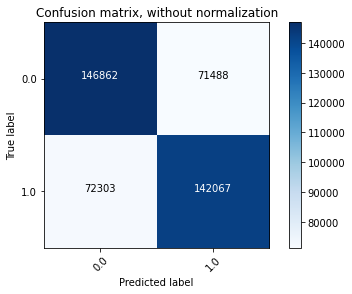

Normalized confusion matrix
[[0.67259904 0.32740096]
 [0.33728134 0.66271866]]


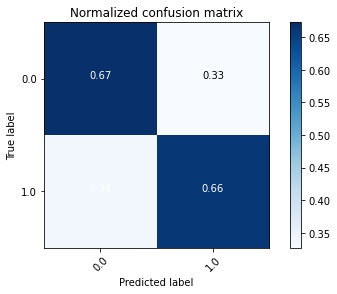

Testing
Accuracy 0.6844729348762981
Confusion matrix, without normalization
[[4764217 2165877]
 [  62726   70292]]


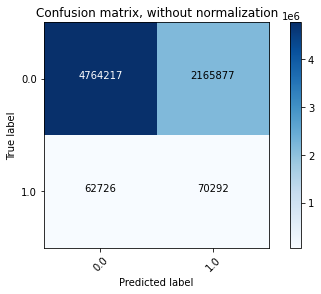

Normalized confusion matrix
[[0.68746788 0.31253212]
 [0.47156024 0.52843976]]


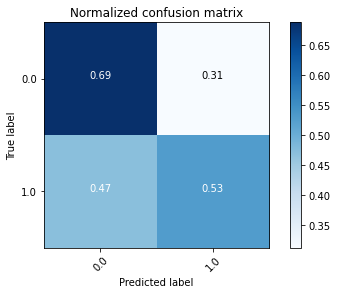

In [10]:
path = "./logistic_regreesion_model"

if os.path.isdir(path):
    model = PipelineModel.load(path)
else:
    model = train("lr", training)
    model.save(path)

# Validation
predictions = model.transform(testing)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Validation")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)

# Testing
predictions = model.transform(test_df)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Testing")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)

### Decision Tree Classifier


Validation
Accuracy 0.5833541320022185
Confusion matrix, without normalization
[[189016  29334]
 [150957  63413]]


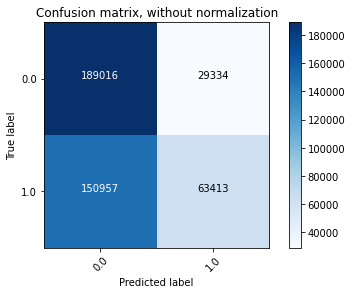

Normalized confusion matrix
[[0.86565606 0.13434394]
 [0.70418902 0.29581098]]


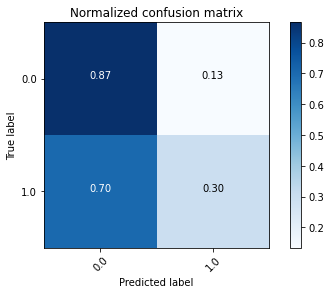

Testing
Accuracy 0.8436465399387691
Confusion matrix, without normalization
[[5931243  998851]
 [ 105491   27527]]


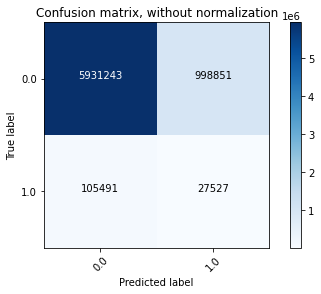

Normalized confusion matrix
[[0.85586761 0.14413239]
 [0.79305808 0.20694192]]


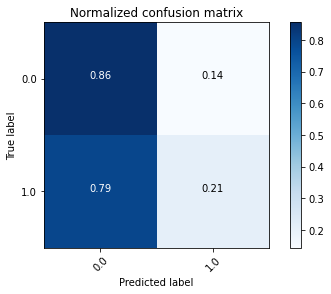

In [12]:
path = "./decision_tree_model"

if os.path.isdir(path):
    model = PipelineModel.load(path)
else:
    model = train("dt", training)
    model.save(path)

# Validation
predictions = model.transform(testing)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Validation")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)

# Testing
predictions = model.transform(test_df)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Testing")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)

### Random Forest Classifier

Validation
Accuracy 0.5747642817526345
Confusion matrix, without normalization
[[186484  31866]
 [152142  62228]]


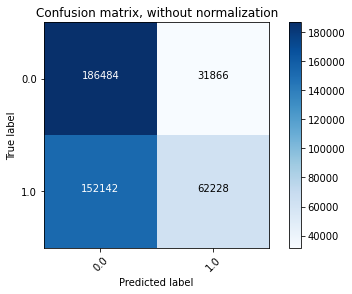

Normalized confusion matrix
[[0.85406    0.14594   ]
 [0.70971684 0.29028316]]


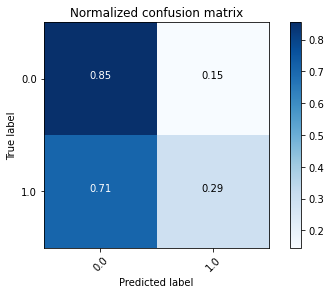

Testing
Accuracy 0.8454763282813581
Confusion matrix, without normalization
[[5941343  988751]
 [ 102667   30351]]


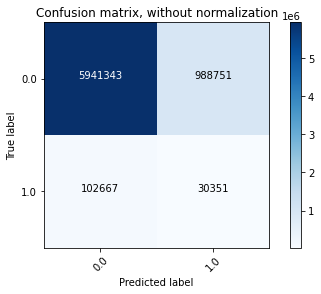

Normalized confusion matrix
[[0.85732502 0.14267498]
 [0.77182787 0.22817213]]


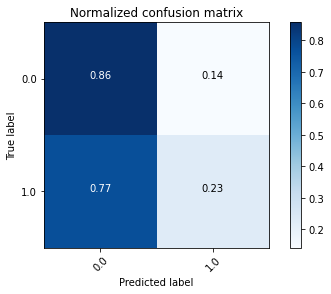

In [13]:
path = "./random_forest_model"

if os.path.isdir(path):
    model = PipelineModel.load(path)
else:
    model = train("rf", training)
    model.save(path)

# Validation
predictions = model.transform(testing)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Validation")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)

# Testing
predictions = model.transform(test_df)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Testing")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)


### Gradient-Boosted Tree Classifier

Validation
Accuracy 0.6423784433351821
Confusion matrix, without normalization
[[155005  63345]
 [ 91405 122965]]


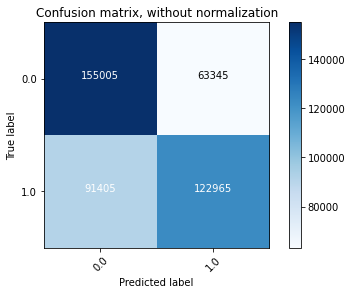

Normalized confusion matrix
[[0.70989237 0.29010763]
 [0.42638895 0.57361105]]


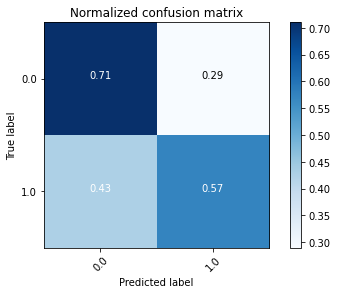

Testing
Accuracy 0.7151889988435692
Confusion matrix, without normalization
[[4988786 1941308]
 [  70344   62674]]


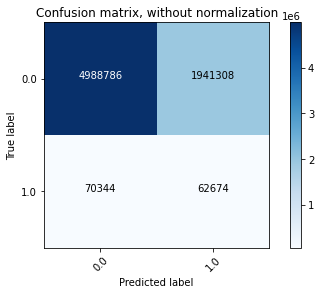

Normalized confusion matrix
[[0.71987278 0.28012722]
 [0.52883068 0.47116932]]


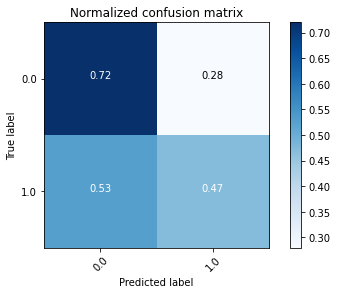

In [14]:
path = "./gradient_boosted_tree_model"

if os.path.isdir(path):
    model = PipelineModel.load(path)
else:
    model = train("gbt", training)
    model.save(path)

# Validation
predictions = model.transform(testing)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Validation")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)

# Testing
predictions = model.transform(test_df)
preds_and_labels = predictions.select(["prediction", "label"])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

class_temp = (
    predictions.select("label")
    .groupBy("label")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)
class_temp = class_temp["label"].values.tolist()

print("Testing")
print("Accuracy", metrics.accuracy)
plot(predictions, class_temp)
